Student Name: Alessandro Gostoli

Student ID: 23251107

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

model.train()

This function to set the model to training mode. We want this because there are some layers that behave in different ways when in train or evaluation mode. That's why before doing one of the two task we need to switch mode

X, y = X.to(device), y.to(device)

This line is needed because we want to use the gpu and to do that we need to send our data and our model to it.

pred = model(X)

In this line we are telling to our model to make predictions based on the input X that we give to it

loss = loss_fn(pred, y)

In this line we are computing the loss using the loss  function given as input. This function will give us information about how far were the predictions from the real data

loss.backward()

In this line we are computing the gradient of the loss function for each parameter

optimizer.step()                    

With this line we are updating the parameters value using the gradient computed in the line above

optimizer.zero_grad()               

This function clears the gradient for each parameter and it is crucial because if we don't call it we will accumulate gradients from previous steps



### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

100%|██████████| 26421880/26421880 [00:02<00:00, 11543836.60it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 213981.42it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3943114.16it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19647203.81it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Sandal  T-shirt/top  Trouser  Trouser  Pullover  Sandal  Coat  Bag  Sandal  Sneaker  Sneaker  Sneaker  Shirt  Coat  Sandal  Pullover  Sandal  Shirt  Trouser  Sandal  Sneaker  Coat  Ankle Boot  Pullover  Coat  Pullover  Trouser  Dress  Coat  Ankle Boot  Trouser  Coat  Sneaker  Bag  Ankle Boot  Bag  Sneaker  Sandal  Sandal  Sandal  Sandal  Coat  Bag  Dress  Pullover  Sneaker  Coat  Dress  Ankle Boot  Sneaker  Pullover  Bag  Coat  Sandal  Bag  Coat  Dress  T-shirt/top  Trouser  Ankle Boot  Shirt  Sandal  Ankle Boot  Bag


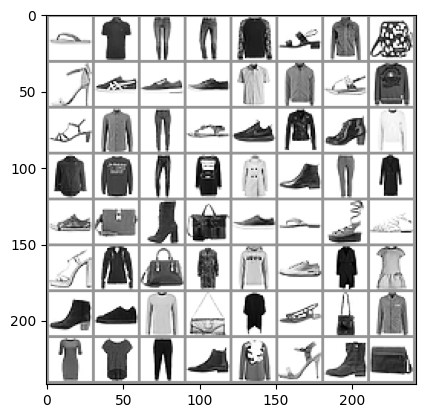

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

mean = 0.2859
std = 0.3530


# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), transforms.Resize((28,28))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=64,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=64,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')



import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(64)))



---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [5]:
import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        m = nn.Flatten()
        x = m(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

random_inputs = torch.rand(64,1,28*28).to(device)

model = NeuralNetwork().to(device)

summary(model, (1,28*28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                  [-1, 100]          10,100
            Linear-3                   [-1, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


In [6]:
pred = model(random_inputs).to(device)

Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

In [7]:
print(pred.shape)

torch.Size([64, 10])


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [8]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

epochs = 15


train_loss, train_accuracy, test_loss, test_accuracy = train_loop(training_loader, validation_loader, model, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.309834  [   64/60000]
loss: 0.593045  [ 6464/60000]
loss: 0.472396  [12864/60000]
loss: 0.334682  [19264/60000]
loss: 0.646782  [25664/60000]
loss: 0.396075  [32064/60000]
loss: 0.337335  [38464/60000]
loss: 0.516294  [44864/60000]
loss: 0.499610  [51264/60000]
loss: 0.484393  [57664/60000]
Train Error: 
 Accuracy: 85.5%, Avg loss: 0.396538 

Test Error: 
 Accuracy: 84.1%, Avg loss: 0.437039 

Epoch 2:

loss: 0.366359  [   64/60000]
loss: 0.351743  [ 6464/60000]
loss: 0.432227  [12864/60000]
loss: 0.455542  [19264/60000]
loss: 0.251813  [25664/60000]
loss: 0.348310  [32064/60000]
loss: 0.356508  [38464/60000]
loss: 0.349302  [44864/60000]
loss: 0.446754  [51264/60000]
loss: 0.388043  [57664/60000]
Train Error: 
 Accuracy: 87.2%, Avg loss: 0.354546 

Test Error: 
 Accuracy: 85.3%, Avg loss: 0.401385 

Epoch 3:

loss: 0.341723  [   64/60000]
loss: 0.250268  [ 6464/60000]
loss: 0.330578  [12864/60000]
loss: 0.472601  [19264/60000]
loss: 0.237326  [25664/60000]
loss: 0.17

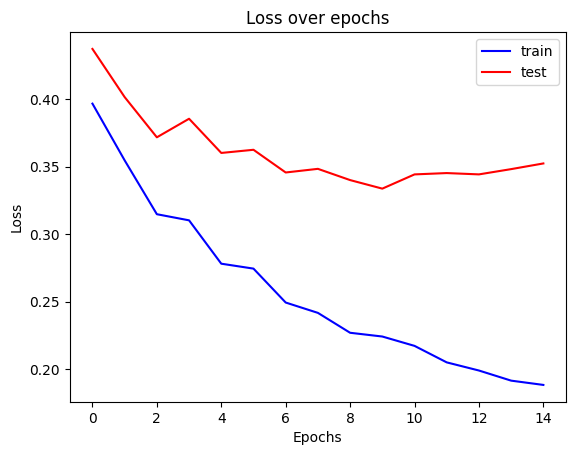

In [9]:


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over epochs")

plt.plot(range(epochs), train_loss, color='b', label='train')
plt.plot(range(epochs), test_loss, color='r', label='test')

plt.legend()
plt.show()

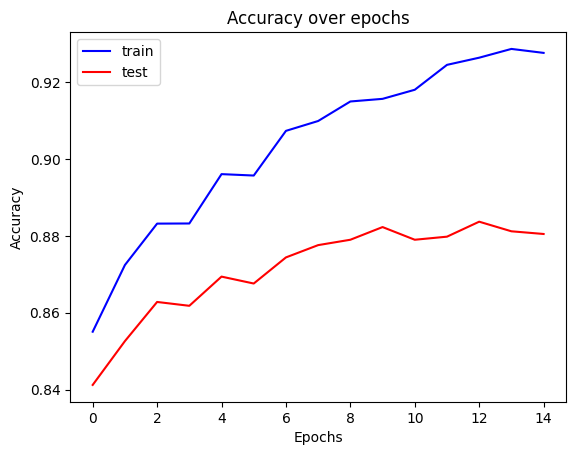

In [10]:

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")

plt.plot(range(epochs), train_accuracy, color='b', label='train')
plt.plot(range(epochs), test_accuracy, color='r', label='test')

plt.legend()
plt.show()

In the plots above we can notice that the training accuracy and loss is constantly improving with very little fluctuations while the test accuracy and loss improve rapidly at the beginning but after some epochs the rate of improvement is decreasing. They are still improving but this process gets slower and slower including some fluctuations. At the end of the training loop the gaps between training and test performances got bigger denoting that the model is a bit overfitted and its capability of generalize on unseen data could be improved


---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

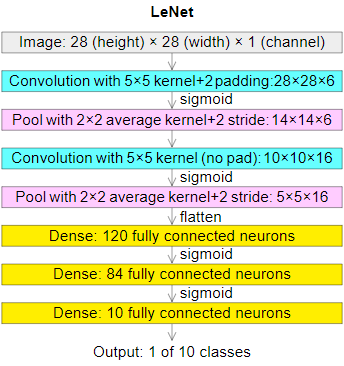

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,padding=2) #28-5+1 * 24 * 6 =
        self.pool1 = nn.AvgPool2d(kernel_size=2,stride=2) # each side / 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,padding=0) #390-5+1 * 386 * 16 = 2383936
        self.pool2 = nn.AvgPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool1(F.sigmoid(self.conv1(x)))
        x = self.pool2(F.sigmoid(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


model = LeNet().to(device)


In [12]:
summary(model, (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [13]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

epochs = 15


train_loss, train_accuracy, test_loss, test_accuracy = train_loop(training_loader, validation_loader, model, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.353969  [   64/60000]
loss: 2.095850  [ 6464/60000]
loss: 1.348096  [12864/60000]
loss: 1.176252  [19264/60000]
loss: 0.837913  [25664/60000]
loss: 0.919066  [32064/60000]
loss: 0.716745  [38464/60000]
loss: 0.755975  [44864/60000]
loss: 0.767688  [51264/60000]
loss: 0.979637  [57664/60000]
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.704617 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.720808 

Epoch 2:

loss: 0.902343  [   64/60000]
loss: 0.764544  [ 6464/60000]
loss: 0.809899  [12864/60000]
loss: 0.717167  [19264/60000]
loss: 0.527235  [25664/60000]
loss: 0.538076  [32064/60000]
loss: 0.528671  [38464/60000]
loss: 0.592656  [44864/60000]
loss: 0.654771  [51264/60000]
loss: 0.694329  [57664/60000]
Train Error: 
 Accuracy: 76.1%, Avg loss: 0.591441 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.620792 

Epoch 3:

loss: 0.666425  [   64/60000]
loss: 0.558605  [ 6464/60000]
loss: 0.583833  [12864/60000]
loss: 0.476740  [19264/60000]
loss: 0.446603  [25664/60000]
loss: 0.50

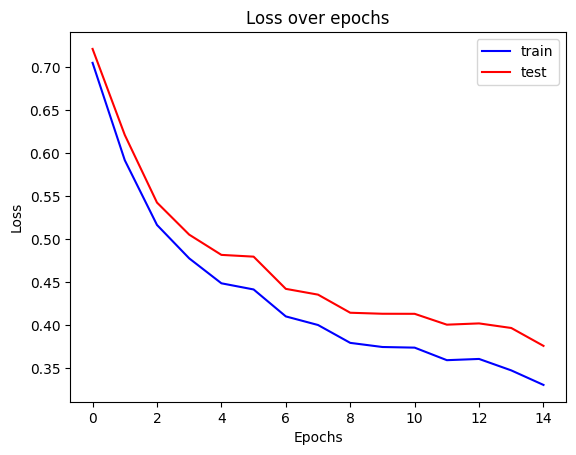

In [14]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over epochs")

plt.plot(range(epochs), train_loss, color='b', label='train')
plt.plot(range(epochs), test_loss, color='r', label='test')

plt.legend()
plt.show()

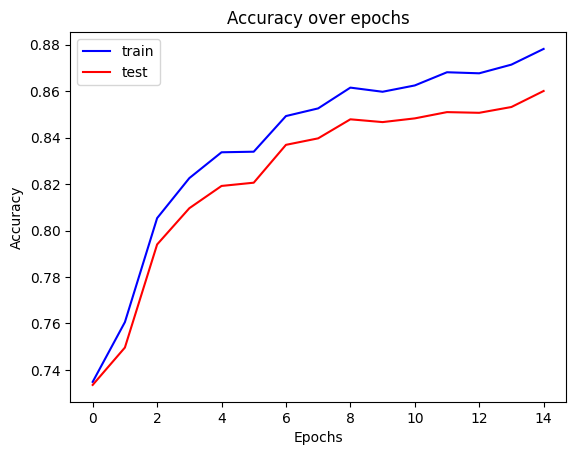

In [15]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")

plt.plot(range(epochs), train_accuracy, color='b', label='train')
plt.plot(range(epochs), test_accuracy, color='r', label='test')

plt.legend()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Task 1 Neural Network:

Parameters: 89,610

Training Performance: 93.3% accuracy, Average Loss: 0.178627

Testing Performance: 88.3% accuracy, Average Loss: 0.341762

LeNet:

Parameters: 61,706

Training Performance: 87.8% accuracy, Average Loss: 0.330225

Testing Performance: 86.0% accuracy, Average Loss: 0.375610



Task 1 Neural Network is more complex with more parameters compared to LeNet 2. Therefore, probably the complexity of the first NN is higher than the second NN.

Talking about the performances the first NN is outperforming the second one in both training and test accuracy and average loss.

Task 1 NN has higher difference between training and testing accuracy than LeNet. This could be a sign of overfitting, because it does a great job on training data but the performance is decreasing on unseen data. However, the actual level of overfitting can only be determined with more in-depth analysis.

The second NN despite being less complex and showing slightly lower performance metrics, might be preferable in scenarios where computational efficiency is required.

Neural Network 1 shows higher training accuracy compared to Neural Network 2. This suggests that Neural Network 1 may be better at learning or fitting the training data.
Neural Network 1 also exhibits a lower average loss during training, indicating better optimization and error minimization on the training set.
Testing Performance:

On the test set, Neural Network 1 again outperforms Neural Network 2. This suggests that Neural Network 1 generalizes better to unseen data.
The lower test loss in Neural Network 1 further supports its better generalization capability.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [16]:
class ModernLeNet(nn.Module):
    def __init__(self):
        super(ModernLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 10)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.batchnorm1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.batchnorm2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

In [17]:
model = ModernLeNet().to(device)

In [18]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         MaxPool2d-2           [-1, 32, 13, 13]               0
       BatchNorm2d-3           [-1, 32, 13, 13]              64
            Conv2d-4           [-1, 64, 11, 11]          18,496
         MaxPool2d-5             [-1, 64, 5, 5]               0
       BatchNorm2d-6             [-1, 64, 5, 5]             128
            Linear-7                   [-1, 64]         102,464
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 10]             650
          Dropout-10                   [-1, 10]               0
Total params: 122,122
Trainable params: 122,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.33
Params size (MB): 0.47
Estimated T

In [19]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

epochs = 15


train_loss, train_accuracy, test_loss, test_accuracy = train_loop(training_loader, validation_loader, model, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.421179  [   64/60000]
loss: 1.348174  [ 6464/60000]
loss: 1.360108  [12864/60000]
loss: 1.630540  [19264/60000]
loss: 1.066630  [25664/60000]
loss: 1.375684  [32064/60000]
loss: 1.167182  [38464/60000]
loss: 1.554648  [44864/60000]
loss: 1.368718  [51264/60000]
loss: 1.173959  [57664/60000]
Train Error: 
 Accuracy: 87.6%, Avg loss: 0.383377 

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.410455 

Epoch 2:

loss: 1.296465  [   64/60000]
loss: 1.273932  [ 6464/60000]
loss: 1.088756  [12864/60000]
loss: 1.234039  [19264/60000]
loss: 1.176111  [25664/60000]
loss: 1.194411  [32064/60000]
loss: 1.108173  [38464/60000]
loss: 1.221333  [44864/60000]
loss: 1.082142  [51264/60000]
loss: 1.041019  [57664/60000]
Train Error: 
 Accuracy: 89.9%, Avg loss: 0.327977 

Test Error: 
 Accuracy: 88.3%, Avg loss: 0.359674 

Epoch 3:

loss: 1.200567  [   64/60000]
loss: 1.114930  [ 6464/60000]
loss: 1.105628  [12864/60000]
loss: 0.882225  [19264/60000]
loss: 1.149056  [25664/60000]
loss: 1.27

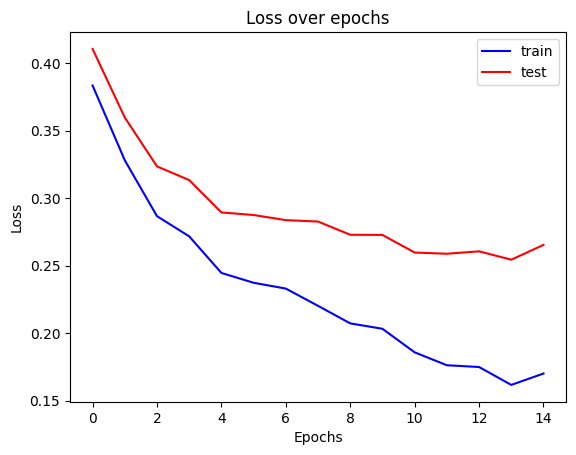

In [20]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over epochs")

plt.plot(range(epochs), train_loss, color='b', label='train')
plt.plot(range(epochs), test_loss, color='r', label='test')

plt.legend()
plt.show()

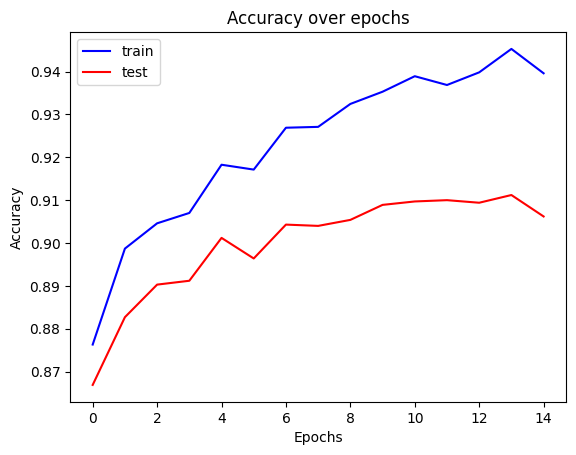

In [21]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")

plt.plot(range(epochs), train_accuracy, color='b', label='train')
plt.plot(range(epochs), test_accuracy, color='r', label='test')

plt.legend()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

LeNet:

Parameters: 61,706

Training Performance: 87.8% accuracy, Average Loss: 0.330225

Testing Performance: 86.0% accuracy, Average Loss: 0.375610

New LeNet:

parameters: 61,706

Training Performance: 94.0% accuracy, Average Loss:  0.170021

Testing Performance: 90.6% accuracy, Average Loss: 0.265298


The differences in the structures of the New LeNet is just MaxPooling instead of AveragePooling and relu function instead of the sigmoid. That's why the two NN have the same number of parameters. In fact, MaxPooling has the same size (2) of Average pooling used in the "Old" LeNet.

The New LeNet outperform the Old on in every metric. In fact it is better in both training and test accuracy and average loss.

The drop in accuracy from training to testing is bigger in the second model,it means that it might be slightly more overfitted to the training data compared to the first model. However, the overall better performance of the second model in both training and testing means that the overfitting is not a very relevant problem.

Overall the second model is performing better having the same complexity as the first one, that's why it might be preferable to choose.


---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [47]:
# class MyNetwork(nn.Module):
#     def __init__(self):
#         super(MyNetwork, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
#         self.batchnorm1 = nn.BatchNorm2d(32)
#         self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
#         self.batchnorm2 = nn.BatchNorm2d(64)
#         self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
#         # self.pool3 = nn.AvgPool2d(kernel_size=64,stride=2)
#         self.fc1 = nn.Linear( 64 * 5 * 5, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):

#         x = self.pool1(F.relu(self.conv1(x)))
#         x = self.batchnorm1(x)
#         x = self.pool2(F.relu(self.conv2(x)))
#         x = self.batchnorm2(x)
#         x = x.view(-1, 64 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 10)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.batchnorm1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.batchnorm2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x


model = MyNetwork().to(device)


In [48]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

epochs = 15


train_loss, train_accuracy, test_loss, test_accuracy = train_loop(training_loader, validation_loader, model, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.381403  [   64/60000]
loss: 1.525213  [ 6464/60000]
loss: 1.232641  [12864/60000]
loss: 1.037134  [19264/60000]
loss: 1.369534  [25664/60000]
loss: 1.200022  [32064/60000]
loss: 1.042420  [38464/60000]
loss: 1.170930  [44864/60000]
loss: 1.108153  [51264/60000]
loss: 1.218659  [57664/60000]
Train Error: 
 Accuracy: 89.1%, Avg loss: 0.348122 

Test Error: 
 Accuracy: 87.8%, Avg loss: 0.374450 

Epoch 2:

loss: 1.089051  [   64/60000]
loss: 0.985059  [ 6464/60000]
loss: 1.236862  [12864/60000]
loss: 1.146522  [19264/60000]
loss: 1.146449  [25664/60000]
loss: 1.435492  [32064/60000]
loss: 1.081420  [38464/60000]
loss: 1.180116  [44864/60000]
loss: 1.130055  [51264/60000]
loss: 1.167881  [57664/60000]
Train Error: 
 Accuracy: 90.4%, Avg loss: 0.304135 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.336168 

Epoch 3:

loss: 1.102034  [   64/60000]
loss: 0.978435  [ 6464/60000]
loss: 1.090868  [12864/60000]
loss: 1.066340  [19264/60000]
loss: 1.094821  [25664/60000]
loss: 0.84

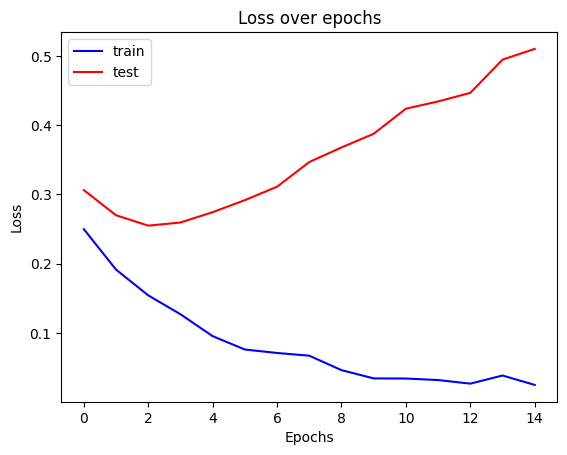

In [26]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over epochs")

plt.plot(range(epochs), train_loss, color='b', label='train')
plt.plot(range(epochs), test_loss, color='r', label='test')

plt.legend()
plt.show()

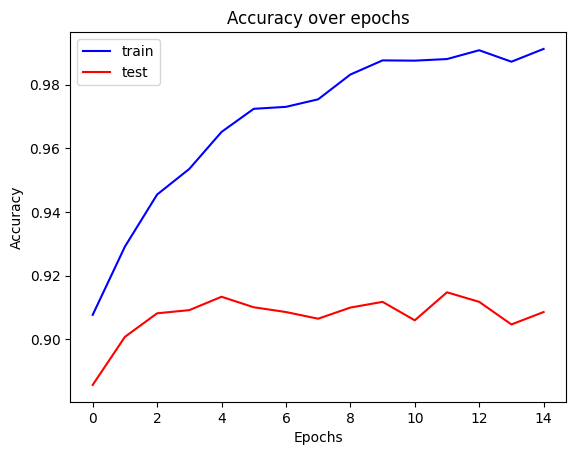

In [27]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")

plt.plot(range(epochs), train_accuracy, color='b', label='train')
plt.plot(range(epochs), test_accuracy, color='r', label='test')

plt.legend()
plt.show()

In [28]:
...

Ellipsis

In [29]:
...

Ellipsis

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

I found on internet the following NN:

def __init__(self):

        super(ModernLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  
        self.fc2 = nn.Linear(128, 10)

def forward(self, x)

    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

This is a typical structure for an CNN. The convolutional layers are used to extract features such as edges, textures, and other patterns. That's why they are very important in machine vision tasks. After using a convolutional layer a MaxPooling layer is used to reduce the dimensionality of the input used in the next layer. After extracting and combining features through convolutional and pooling layers, the network uses fully connected layers to classify the input image into various classes based on the learned features.


Subsequently i added batch normalization layer as was suggested. This implementation was giving very good result: Training accuracy 99.2% and test accuracy 90.7%. Despite the good performance on test data it was clear that the model was really overfitting the training data. That's why i tried to reduce the overfitting introducing dropout layers and reducing the size of the last fully connected layer resulting in the final implemetation. Dropout is a regularization technique where randomly selected neurons are ignored during training. By randomly taking a break some of the neurons during training, the network doesn't get stuck on any specific neuron's importance. It's like not letting the network rely too much on any one feature it learns, which helps it to be more flexible. This way, the network gets better at making good guesses on new data it hasn't seen before, without just memorizing the examples it was trained on.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [30]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

## Task 1

In [31]:
model = torchvision.models.resnet18(weights=None).to(device)

In [32]:
summary(model, (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [34]:
model.fc = nn.Linear(512, 10).to(device)

In [35]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model


epochs = 15


train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.558992  [   64/60000]
loss: 0.556802  [ 6464/60000]
loss: 0.390294  [12864/60000]
loss: 0.512744  [19264/60000]
loss: 0.470322  [25664/60000]
loss: 0.413796  [32064/60000]
loss: 0.298988  [38464/60000]
loss: 0.465723  [44864/60000]
loss: 0.312824  [51264/60000]
loss: 0.371293  [57664/60000]
Train Error: 
 Accuracy: 86.7%, Avg loss: 0.345766 

Test Error: 
 Accuracy: 85.3%, Avg loss: 0.389482 

Epoch 2:

loss: 0.271261  [   64/60000]
loss: 0.337324  [ 6464/60000]
loss: 0.264667  [12864/60000]
loss: 0.299729  [19264/60000]
loss: 0.375811  [25664/60000]
loss: 0.335701  [32064/60000]
loss: 0.240564  [38464/60000]
loss: 0.417487  [44864/60000]
loss: 0.278101  [51264/60000]
loss: 0.341991  [57664/60000]
Train Error: 
 Accuracy: 88.8%, Avg loss: 0.295866 

Test Error: 
 Accuracy: 87.3%, Avg loss: 0.349087 

Epoch 3:

loss: 0.256217  [   64/60000]
loss: 0.240088  [ 6464/60000]
loss: 0.208026  [12864/60000]
loss: 0.250643  [19264/60000]
loss: 0.300614  [25664/60000]
loss: 0.33

# Task 2

In [36]:
weights = torchvision.models.ResNet18_Weights

In [38]:
model = torchvision.models.resnet18(weights=weights).to(device)

model.fc = nn.Linear(512, 10).to(device)
# params = model.state_dict()
# params.keys()

In [39]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

epochs = 15


train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs)



Epoch 1:

loss: 2.527542  [   64/60000]
loss: 0.569380  [ 6464/60000]
loss: 0.356738  [12864/60000]
loss: 0.395490  [19264/60000]
loss: 0.709074  [25664/60000]
loss: 0.420279  [32064/60000]
loss: 0.282371  [38464/60000]
loss: 0.426815  [44864/60000]
loss: 0.245432  [51264/60000]
loss: 0.322611  [57664/60000]
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.342342 

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.381587 

Epoch 2:

loss: 0.300134  [   64/60000]
loss: 0.298706  [ 6464/60000]
loss: 0.307556  [12864/60000]
loss: 0.277132  [19264/60000]
loss: 0.349633  [25664/60000]
loss: 0.353210  [32064/60000]
loss: 0.290788  [38464/60000]
loss: 0.351286  [44864/60000]
loss: 0.239283  [51264/60000]
loss: 0.210369  [57664/60000]
Train Error: 
 Accuracy: 88.3%, Avg loss: 0.319209 

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.366019 

Epoch 3:

loss: 0.222727  [   64/60000]
loss: 0.278643  [ 6464/60000]
loss: 0.189293  [12864/60000]
loss: 0.228644  [19264/60000]
loss: 0.268363  [25664/60000]
loss: 0.33

# Task 3

In [40]:
#model = torchvision.models.resnet18(weights=weights).to(device)

# net_add= OneLayerToAdd().to(device)

# model.fc = nn.Linear(512,10).to(device)

for name, param in model.named_parameters():
      param.requires_grad = False


In [41]:
model.fc = nn.Linear(512,10).to(device)

In [42]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [43]:
# model.fc.requires_grad_ = True

In [44]:
params = model.state_dict()
params.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [45]:
summary(model, (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [46]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

epochs = 15


train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs)



Epoch 1:

loss: 2.495375  [   64/60000]
loss: 0.182337  [ 6464/60000]
loss: 0.063168  [12864/60000]
loss: 0.139406  [19264/60000]
loss: 0.107991  [25664/60000]
loss: 0.126392  [32064/60000]
loss: 0.079102  [38464/60000]
loss: 0.063638  [44864/60000]
loss: 0.026706  [51264/60000]
loss: 0.015467  [57664/60000]
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.058732 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.326351 

Epoch 2:

loss: 0.076851  [   64/60000]
loss: 0.116901  [ 6464/60000]
loss: 0.035455  [12864/60000]
loss: 0.138196  [19264/60000]
loss: 0.087868  [25664/60000]
loss: 0.130248  [32064/60000]
loss: 0.076723  [38464/60000]
loss: 0.063959  [44864/60000]
loss: 0.016479  [51264/60000]
loss: 0.010896  [57664/60000]
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.055093 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.351589 

Epoch 3:

loss: 0.072463  [   64/60000]
loss: 0.114230  [ 6464/60000]
loss: 0.036711  [12864/60000]
loss: 0.137055  [19264/60000]
loss: 0.082727  [25664/60000]
loss: 0.13

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

In the first approach we load the ResNet18 model without pre-trained weights, which means the model starts with random weights. Then, we replace the last fully connected layer  a new fully connected layer to match the number of outputs to your our task. This approach is like building a new model using the resnet architecture. Since the weights are initialized randomly, the model does not have any prior knowledge and learns everything from scratch during training.

In the second approach we load the resnet with its default parameters, which means loading it with pre-trained weights. This approach apply transfer learning since the model already knows how to extract general features and only needs to learn the specifics of our dataset.

In the last approach we froze all the layers beside the last one whcih is the one we added manually. By freezing the initial layers, we are just training the last layer.
This appproch assumes that the pre-trained layers are already good at extracting relevant features.


Approach 1:

Train Error:
Accuracy: 95.7%, Avg loss: 0.137037

Test Error:
Accuracy: 90.5%, Avg loss: 0.451769



Approach 2:

Train Error:
Accuracy: 96.9%, Avg loss: 0.084998

Test Error:
Accuracy: 90.9%, Avg loss: 0.388426

Approach 3:

Train Error:
Accuracy: 98.2%, Avg loss: 0.049424

Test Error:
Accuracy: 91.5%, Avg loss: 0.390177


Since this model started with random weights, all the learning was done from scratch. An accuracy of 96.1% on the training set says that the model learned well from the training data. The test accuracy of 90.9% means that the model can generalize well on unseen data, but the higher test loss compared to the training loss indicates some overfitting. Probably the overfitting is caused by the fact that the model could have learnt some noise or pattern that are not useful for our classification.
The second model relies on existing knowledge from the dataset it was trained on since it is starting with pre-trained weights. The slightly better training accuracy and similar test accuracy compared to the first approach indicate that transfer learning had little positive effect.
The slightly higher test loss compared to the first model could be caused by the fact that the pre-trained features don't match exactly our specific data.
The last approach has the highest training accuracy and lowest training loss. We actually expected that since the pre-trained layers are frozen and only the last layer, which is fitting our specific task, is being trained.
This approach has the best test accuracy among the three approaches and the lowest test loss. That indicates that freezing the initial layers and only training the last layer worked well for your data. This could mean that the features learned by the pre-trained network were relevant and useful for your task.